In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'indonesia-tourism-destination:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1481754%2F2448367%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240520T125645Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9623c357237811ca5478fd9643ed3d8fb58c692a314183ad69cf1ef6095ca72190b9caeb67d0dc0441e928c9fb9b184adeab795ae787b6c2c2232394152d46ac09f86f8a1141f611646808f8062ae249c29ee6759f5b0f30a8a184f6b3993e970a627210222cb1ed6bd0044e082d6e0f7e472538673c4b6cd63b5070733ac3f6a26d8fb456ea67d7d85aef4ec6b7d05e532c99ac97db3696d5905df6bdb25997feb8623cf04d59d08383570a28eac3b2abadc91e05eba22f68c3a21bbccd9c16cf15984ab2f7bb90c237192aed2823e768397a63741aba60bb14ab309129700a5558ef5667f8e4ab73fb28033d9618d099137f6032f366e0b21aab3af3d65121'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 162193 bytes downloaded
Downloaded and uncompressed: indonesia-tourism-destination
Data source import complete.


# Sistem Rekomendasi Destinasi Wisata Kota Bandung Berbasis Collaborative Filtering
<hr>

#### Sumber data: https://www.kaggle.com/aprabowo/indonesia-tourism-destination
#### Oleh: [Rafka Imanda Putra](https://www.kaggle.com/rafkaip)

# Pendahuluan

<div>
<img src="https://static.limakaki.com/2017/07/slide_12.jpg" width="900";/>
</div>

Sebelum bepergian, biasanya seseorang akan membuat rencana terlebih dahulu tentang lokasi yang akan dikunjungi dan waktu keberangkatannya. Hal ini dilakukan untuk perencanaan sebelum berwisata ke suatu Kota.

Kota Bandung memiliki daya tarik wisata yang cukup tinggi, namun dikutip dari humas.bandung.go.id/ jumlah wisatawan ke Kota Bandung turun 50% pada tahun 2021. Tentunya angka ini wajar karena penyebaran Covid-19 yang mengkhawatirkan di Indonesia.

Untuk periode Oktober 2021, sejumlah wisata di Kota Bandung sudah mulai beroperasi, ini akan menjadi momentum yang tepat untuk menggerakkan pariwisata kembali.

Pada projek ini, saya akan membuat sebuah sistem rekomendasi berbasis collaborative filtering untuk menampilkan top-n recommendation destinasi wisata di Kota Bandung berdasarkan data user, rating, dan place

# Alur Proses

## 1. Mengimpor Library Python yang Dibutuhkan

In [101]:
# Untuk pengolahan data
import pandas as pd
import numpy as np
from zipfile import ZipFile
from pathlib import Path

# Untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_palette('Set1')
sns.set()

# Untuk pemodelan
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Untuk menghilangkan warnings saat plotting seaborn
import warnings
warnings.filterwarnings('ignore')

# Untuk mengupload file
import os

## 2. Menyiapkan Dataset yang digunakan

##### Keterangan:
* tourism_with_id.csv - mengandung informasi tempak wisata di 5 kota besar di Indonesia (hanya kota Bandung yang dipakai)
* user.csv - mengandung informasi pengguna untuk membuat rekomendasi fitur berdasar pengguna
* tourism_rating.csv - mengandung informasi pengguna, tempat wisata, dan rating untuk membuat sistem rekomendasi berdasar rating


## 3. Data Understanding

### 3.1 Menyiapkan Data

In [102]:
# Menyimpan masing-masing dataset kedalam variabel

rating = pd.read_csv('/home/tourism_rating.csv')
place = pd.read_csv('/home/tourism_with_id.csv')
user = pd.read_csv('/home/user.csv')

### 3.2 Eksplorasi Fitur-fitur pada Data

#### 3.2.1. Data place

In [103]:
# Melihat gambaran data place

place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1.0,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1.0
1,2.0,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2.0


In [104]:
# Membuang kolom yang tidak dipakai

place = place.drop(['Unnamed: 11','Unnamed: 12'],axis=1)
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1.0,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2.0,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125


In [105]:
# Merubah data agar hanya dari Kota Bandung

place = place[place['City']=='Malang']
place.head(2)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
437,438.0,Jatim Park 1,Taman rekreasi edukasi dengan berbagai wahana ...,Taman Rekreasi,Malang,NaN,4.5,NaN,"{'lat': -7.883131, 'lng': 112.533232}",-7.883131,112.533232
438,439.0,Jatim Park 2 (Batu Secret Zoo & Museum Satwa),Kebun binatang modern dan museum satwa dengan ...,"Kebun Binatang, Museum",Malang,NaN,4.7,NaN,"{'lat': -7.883479, 'lng': 112.533682}",-7.883479,112.533682


In [106]:
place.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 437 to 493
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      57 non-null     float64
 1   Place_Name    57 non-null     object 
 2   Description   57 non-null     object 
 3   Category      57 non-null     object 
 4   City          57 non-null     object 
 5   Price         2 non-null      float64
 6   Rating        57 non-null     float64
 7   Time_Minutes  0 non-null      float64
 8   Coordinate    57 non-null     object 
 9   Lat           57 non-null     float64
 10  Long          57 non-null     float64
dtypes: float64(6), object(5)
memory usage: 5.3+ KB


In [107]:
# Membuang kolom yang tidak dipakai

place = place.drop('Time_Minutes', axis=1)

#### 3.2.2. Data rating

In [108]:
# melihat gambaran data rating

rating.head()

,User_Id,Place_Id,Place_Ratings,Unnamed: 3,Unnamed: 4
0,1,179,3,NaN,NaN
1,1,344,2,NaN,NaN
2,1,5,5,NaN,NaN
3,1,373,3,NaN,NaN
4,1,101,4,NaN,NaN


In [113]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        300 non-null    int64
 1   Place_Id       300 non-null    int64
 2   Place_Ratings  300 non-null    int64
dtypes: int64(3)
memory usage: 7.2 KB


In [110]:

rating = rating.drop(['Unnamed: 3','Unnamed: 4'],axis=1)

In [111]:
# Merubah data rating agar hanya berisi rating pada tempat wisata dari Kota Bandung

rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,438,2
1,20,438,2
2,39,438,3
3,58,438,2
4,77,438,5


In [112]:
# Melihat ukuran dataset rating untuk Kota Bandung

rating.shape

(300, 3)

#### 3.2.3. Data user

In [100]:
# Melihat gambaran data user

user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
6,2,"Bekasi, Jawa Barat",21
12,3,"Cirebon, Jawa Barat",23
18,4,"Bekasi, Jawa Barat",21
24,5,"Lampung, Sumatera Selatan",20


In [114]:
# Merubah data user agar hanya berisi user yang pernah megunjungi wisata di Kota Bandung

user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id').drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
6,2,"Bekasi, Jawa Barat",21
12,3,"Cirebon, Jawa Barat",23
18,4,"Bekasi, Jawa Barat",21
24,5,"Lampung, Sumatera Selatan",20


In [115]:
# Melihat dataset user yang pernah memberi rating pada wisata di Kota Bandung

user.shape

(300, 3)

## 4. Eksplorasi Data

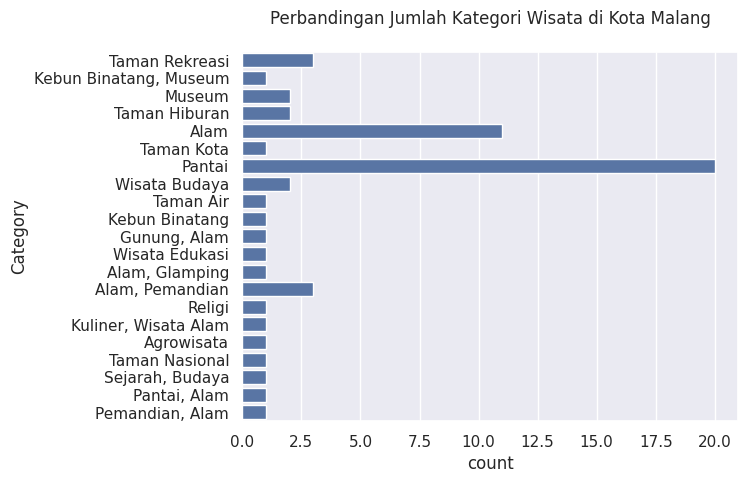

In [116]:
# Membuat visualisasi jumlah kategori wisata di Kota Bandung

sns.countplot(y='Category', data=place)
plt.title('Perbandingan Jumlah Kategori Wisata di Kota Malang', pad=20)
plt.show()

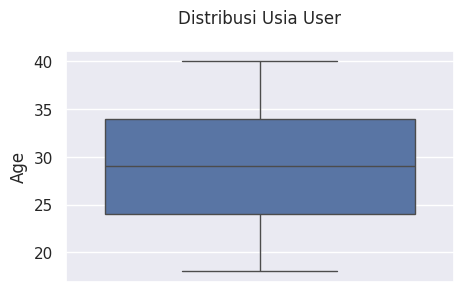

In [117]:
# Membuat visualisasi distribusi usia user

plt.figure(figsize=(5,3))
sns.boxplot(user['Age']);
plt.title('Distribusi Usia User', pad=20)
plt.show()

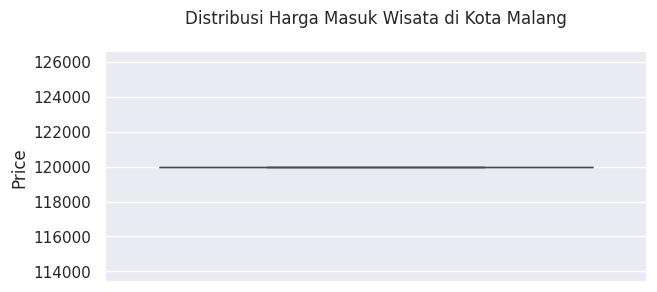

In [118]:
# Membuat visualisasi distribusi harga masuk tempat wisata

plt.figure(figsize=(7,3))
sns.boxplot(place['Price'])
plt.title('Distribusi Harga Masuk Wisata di Kota Malang', pad=20)
plt.show()

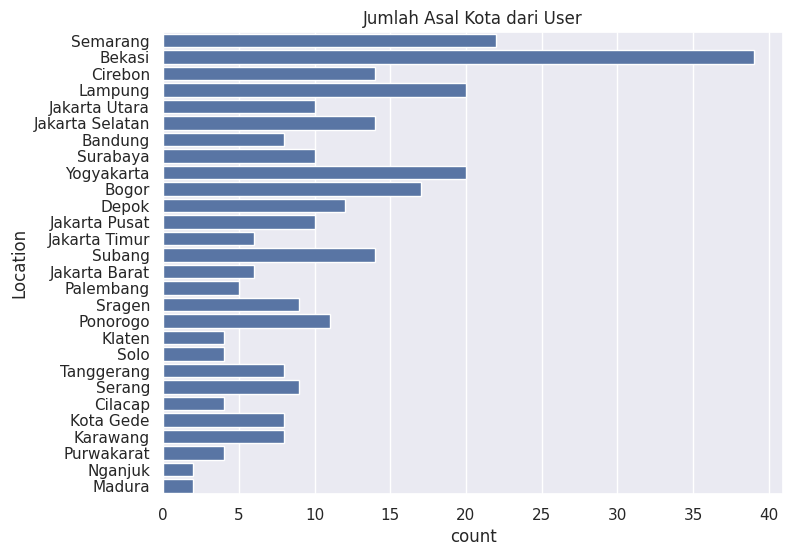

In [119]:
# Memfilter asal kota dari user
askot = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8,6))
sns.countplot(y=askot)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## 5. Persiapan Data untuk Pemodelan

### 5.1. Membuat Salinan Data rating

In [120]:
# Membaca dataset untuk dilakukan encoding

df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,1,438,2
1,20,438,2
2,39,438,3
3,58,438,2
4,77,438,5


### 5.2. Melakukan Encoding

#### 5.2.1. Membuat Fungsi untuk Melakukan Encoding

In [124]:
def dict_encoder(col, data=df):

  # Mengubah kolom suatu dataframe menjadi list tanpa nilai yang sama
  unique_val = data[col].unique().tolist()

  # Melakukan encoding value kolom suatu dataframe ke angka
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}

  # Melakukan proses encoding angka ke value dari kolom suatu dataframe
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

#### 5.2.2. Encoding dan Mapping Kolom User

In [125]:
# Encoding User_Id
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

# Mapping User_Id ke dataframe
df['user'] = df['User_Id'].map(user_to_user_encoded)

#### 5.2.3. Encoding dan Mapping Kolom Place

In [126]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

### 5.3. Melihat Gambaran Data untuk Pemodelan

In [127]:
# Mendapatkan jumlah user dan place
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)

# Mengubah rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating: {max_rating}')

Number of User: 300, Number of Place: 57, Min Rating: 1.0, Max Rating: 5.0


In [128]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head(2)

,User_Id,Place_Id,Place_Ratings,user,place
203,258,476,2.0,203,38
266,232,488,3.0,266,50


## 6. Pemodelan Machine Learning dengan RecommenderNet

### 6.1. Membagi data train dan test

In [135]:
# Membuat variabel x untuk mencocokkan data user dan place menjadi satu value
x = df[['user', 'place']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.80 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### 6.2. Menyiapkan Model

#### 6.2.1. Inisialisasi Fungsi

In [164]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-1)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.places_embedding = layers.Embedding( # layer embeddings places
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-1)
    )
    self.places_bias = layers.Embedding(num_places, 1) # layer embedding places bias

    self.user_dropout = layers.Dropout(0.5)  # Contoh dropout dengan rate 0.5
    self.places_dropout = layers.Dropout(0.5)  # Contoh dropout dengan rate 0.5

  def call(self, inputs):
    #user_vector = self.user_dropout(user_vector)
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    places_vector = self.places_embedding(inputs[:, 1]) # memanggil layer embedding 3
    user_vector = self.user_dropout(user_vector)
    places_bias = self.places_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_places = tf.tensordot(user_vector, places_vector, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x) # activation sigmoid

#### 6.2.2. Inisialisasi Model

In [173]:
model = RecommenderNet(num_users, num_place, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

#### 6.2.2. Inisialisasi Callbacks

In [174]:
 class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

#### 6.2.3. Proses Training

In [179]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks = [myCallback()]
)

Epoch 1/100
8/8 [==============================] - 0s 17ms/step - loss: 0.6083 - root_mean_squared_error: 0.2679 - val_loss: 0.6758 - val_root_mean_squared_error: 0.3319
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 0.6080 - root_mean_squared_error: 0.2676 - val_loss: 0.6757 - val_root_mean_squared_error: 0.3318
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6077 - root_mean_squared_error: 0.2673 - val_loss: 0.6757 - val_root_mean_squared_error: 0.3318
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6073 - root_mean_squared_error: 0.2670 - val_loss: 0.6756 - val_root_mean_squared_error: 0.3317
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.6070 - root_mean_squared_error: 0.2667 - val_loss: 0.6756 - val_root_mean_squared_error: 0.3317
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.6067 - root_mean_squared_error: 0.2664 - val_loss: 0.6755 - val_root_mean_squared

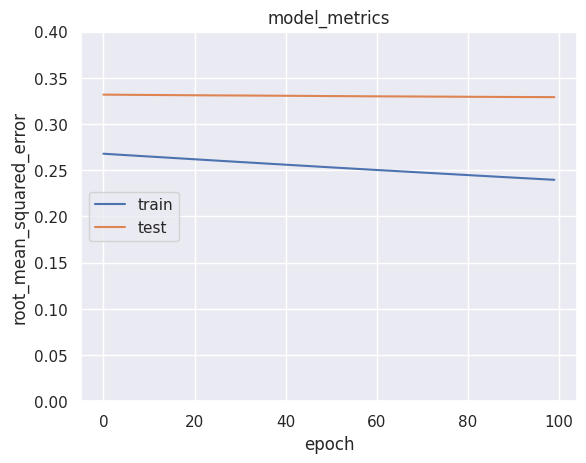

In [180]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

KeyError: 'val_accuracy'

## 7. Memprediksi Top 7 Rekomendasi

#### 7.1 Menyiapkan DataFrame untuk Menampilkan Hasil Rekomendasi

In [47]:
# Menyiapkan dataframe
place_df = place[['Place_Id','Place_Name','Category','Rating','Price']]
place_df.columns = ['id','place_name','category','rating','price']
df = rating.copy()

#### 7.2. Menyiapkan contoh User untuk Menampilkan Rekomendasi

#### 7.2.1 Mencari User

In [48]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

#### 7.2.2. Mencari Lokasi yang belum Dikunjungi User

In [49]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)

place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

### 7.3. Menampilkan Hasil Rekomendasi untuk User

In [50]:
# Mengambil top 7 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Daftar rekomendasi untuk: {}'.format('User ' + str(user_id)))
print('===' * 15,'\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)

place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
    print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)

recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.place_name, '\n    ', row.category, ',', 'Harga Tiket Masuk ', row.price, ',', 'Rating Wisata ', row.rating,'\n')

print('==='*15)

2/2 [==============================] - 0s 6ms/step
Daftar rekomendasi untuk: User 110

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
Masjid Tiban Turen : Religi

------------------------------------------------------------
Top 7 place recommendation
------------------------------------------------------------
1 . Coban Pelangi 
     Alam , Harga Tiket Masuk  nan , Rating Wisata  4.4 

2 . Batu Flower garden 
     Taman Rekreasi , Harga Tiket Masuk  120000.0 , Rating Wisata  4.1 

3 . Coban Putri 
     Alam , Harga Tiket Masuk  nan , Rating Wisata  4.5 

4 . Bukit Teletubbies Bromo 
     Alam , Harga Tiket Masuk  nan , Rating Wisata  4.6 

5 . Sumber Maron 
     Alam, Pemandian , Harga Tiket Masuk  nan , Rating Wisata  4.3 

6 . Pantai Clungup 
     Pantai , Harga Tiket Masuk  nan , Rating Wisata  4.5 

7 . Pantai Kondang Merak 
     Pantai , Harga Tiket Masuk 

# Penutup

Model untuk menampilkan top 7 rekomendasi tempat wisata telah selesai dibuat dan model ini dapat digunakan untuk menampilkan rekomendasi kepada user yang harapannya dapat meningkatkan jumlah wisatawan di Kota Bandung. Namun demikian beberapa pengembangan lain masih dapat dilakukan agar dapat membuat model yang menampilkan rekomendasi yang lebih sesuai dengan kebiasaan pengguna, dll.

## *Referensi*

* Seaborn : https://seaborn.pydata.org/tutorial.html
* Callback : https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
* Lainnya:
  * https://github.com/AgungP88/getloc-apps/tree/machine-learning
  * https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system
  * https://www.kaggle.com/aprabowo/indonesia-tourism-destination
  * https://www.dicoding.com/academies/319